# **Introduction**

In the previous project `Mall Customer Segmentation` **K-Means** were used. Now, let's use **DBSCAN**. What's the differences?

**K-Means** has two big flaws:
1. We must guess K: We have to tell it "find 5 clusters." (What if there are actually 7?)
2. It forces everyone into a group: Even a weirdo outlier gets forced into a cluster.
3. It assumes circles: It loves round blobs. If your data is shaped like a banana or a ring, K-Means fails.

**DBSCAN** solves this:
* It **finds the number of clusters automatically**.
* It **identifies outliers** (noise) and labels them as "-1" (meaning: "This peron fits nowhere").
* It handles **weird shapes.**

---

## **The "Credit Card Power User" Analysis**

We need a bigger, messier dataset. We will use the **Credit Card Dataset**:
* **Size:** ~9000 customers.
* **Features:** 18 columns (Balance, Cash Advance, Purchases, Credit Limit, etc.)
* **Goal:** Group them based on *how* they use their card (e.g., "Cash Advance Addicts" vs. "Installment Payers")

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv('CC GENERAL.csv')

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### **Preprocess**
**DBSCAN** is *very sensitive* to scale. We cannot compare `Balance` (Values liek $5,000) with `Frequency` (Values like 0.5) directly. We must *scale* the data.

Also, this dataset has 18 dimensions. We can't visualize 18D. We will use a technique called **PCA (Principal Component Analysis)** to squash those 18 columns down to 2 *"Super Columns"* just for visualization.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clean Data (Drop 'Id', Fill missing Values)
df = df.drop('CUST_ID', axis=1)
df.ffill(inplace=True) # Simple Forward Fill

print(f"Shape: {df.shape}")

# Scale the data (Mandatory)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Simplify to 2D for plotting (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Data Scaled and PCA-Ready!")

Shape: (8950, 17)
Data Scaled and PCA-Ready!


#### **"DBSCAN" Test
**DBSCAN** takes two parameters:
1. `eps` **(Epsilon)**: The maximum distance between two samples for one to be considered as in the neighborhood of the other. (Think of it as the "Radius of the circle" around a person).
2. `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. (The "Minimum friends required to form a gang").

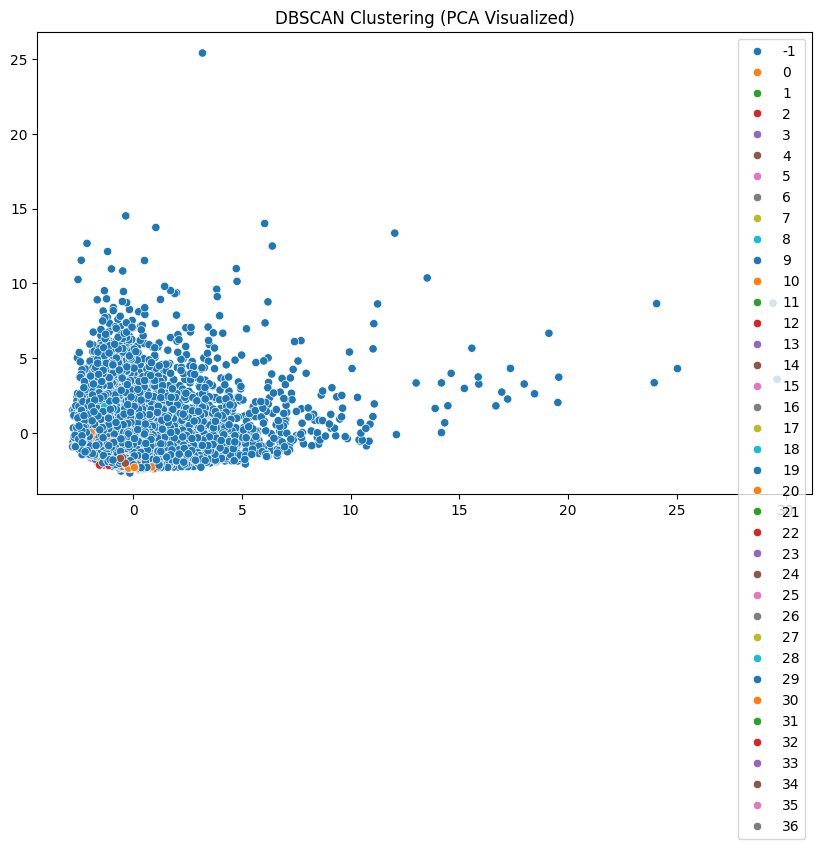

Estimated number of clusters: 37
Estimated number of noise points: 6643


In [5]:
from sklearn.cluster import DBSCAN

# eps=0.5 (Radius), min_samples=5 (Min people to form a group)
# We might need to tune them later!
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Add to our PCA data to visualize
# Note: -1 means "Outlier/Noise"
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:, 1], hue=clusters, palette='tab10', legend='full')
plt.title('DBSCAN Clustering (PCA Visualized)')

plt.show()

#Count the clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

This result is a classic "DBSCAN Trap".
* Total Data: ~8950 rows.
* Noise Points (-1): 6,643 (This is ~74% of the data).
* Clusters: 37 (Way too many)

**The Diagnosis:** The model is **too strict**. Think of `eps=0.5` as the "arm span" of each data point.Right now, the arm span is too short. 74% of customers are reaching out and touching *no one*, so the model labels them as "loners" (Noise).

We need to increase the `eps` (arm span) to connect more people. But instead of guessing, we use the **"K-Distance Graph"** (The DBSCAN version of the Elbow Method) to find the perfect number.

---

#### **Finding the Perfect Epsilon (The Knee Method)**
We calculate the distance to the nearest *N* neighbors for every single data point and plot it.
* Flat part: Points are close together (Clusters).
* Vertical spike: Points are far apart (Noise).
* The "Knee": The perfect cutoff for `eps`.

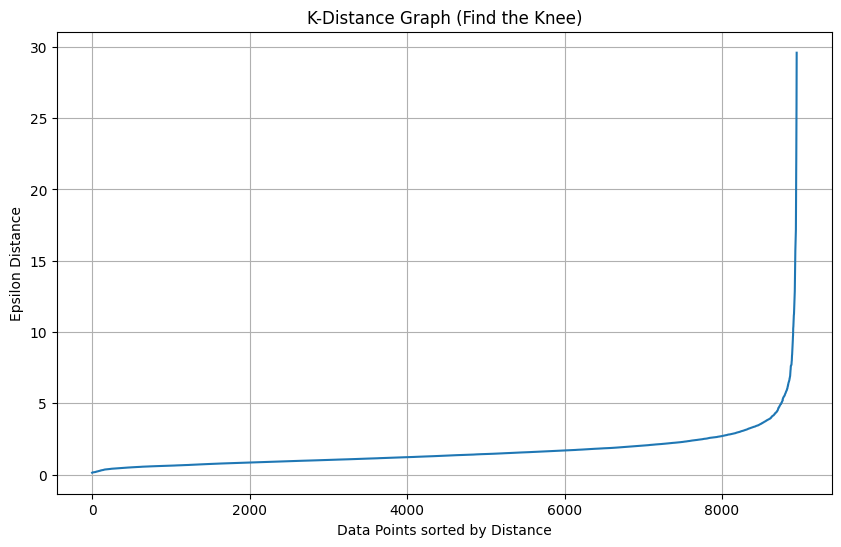

In [16]:
from sklearn.neighbors import NearestNeighbors

# 1. Initialize Nearest Neighbors (min_samples is usually 2*dimensions)
# We have 17 dimensions, so let's look at the 34th nearerst neighbor
neigh = NearestNeighbors(n_neighbors=34)
nbrs = neigh.fit(X_scaled)

# 2. Calculate distances to nearest neighbors
distances, indices = nbrs.kneighbors(X_scaled)

# 3. Sort and plot distances
distances = np.sort(distances[:, 33], axis=0) # Look at the 34th neighbor distance

plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph (Find the Knee)")
plt.xlabel("Data Points sorted by Distance")
plt.ylabel("Epsilon Distance")
plt.grid(True)

plt.show()

From the graph, we can see:
* The Flat Part: The line stays very low (below 2.5) for the first ~8000 data points. This represents the "dense" normat data.
* The Spike: Around the ~8500 point, the line shoots straight up to 30.
* The Knee: The crucial turning point seems to be right around `eps = 3.5` to `4.0`

If we pick `4.0` we are saying: *"Anyone within the distance of 4.0 is a neighbor. Anyone further away is an outlier."*

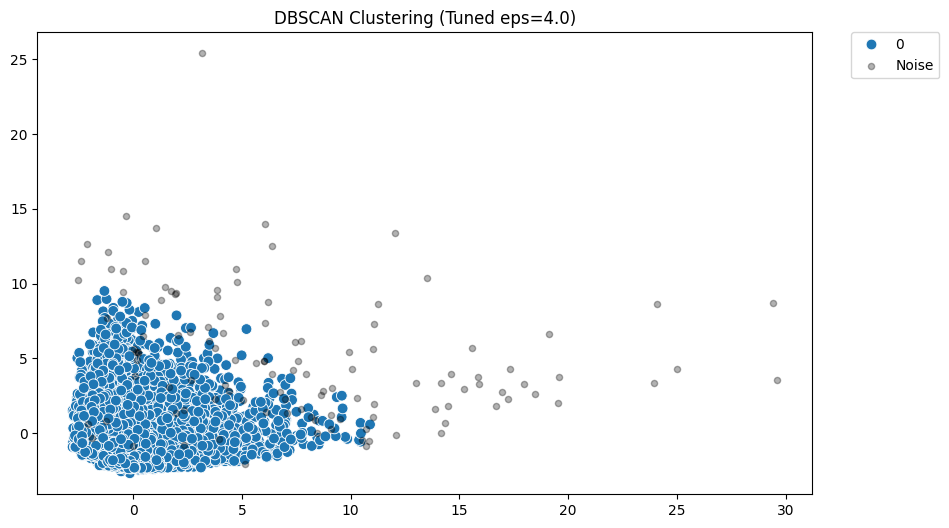

--- Final Results ---
 Clusters Found: 1
Noise Points: 119


In [17]:
# UPDATE: Tuned DBSCAN based on your graph
# We picked 4.0 becuase that's where the curve bends upwards
dbscan_tuned = DBSCAN(eps=4.0, min_samples=10)
clusters_tuned = dbscan_tuned.fit_predict(X_scaled)

# Add to PCA data for plotting
plt.figure(figsize=(10,6))

# Plot non-noise points
sns.scatterplot(x=X_pca[clusters_tuned != -1, 0],
                y=X_pca[clusters_tuned != -1, 1],
                hue=clusters_tuned[clusters_tuned != -1],
                palette='tab10', legend='full', s=60)

# Plot Noise points in Gray/Black
plt.scatter(X_pca[clusters_tuned == -1, 0],
            X_pca[clusters_tuned == -1, 1],
            s=20, c='black', label='Noise', alpha=0.3)

plt.title("DBSCAN Clustering (Tuned eps=4.0)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Calculate stats
n_clusters_final = len(set(clusters_tuned)) - (1 if -1 in clusters_tuned else 0)
n_noise_final = list(clusters_tuned).count(-1)

print(f"--- Final Results ---")
print(f" Clusters Found: {n_clusters_final}")
print(f"Noise Points: {n_noise_final}")

Now the eps is too big (Cluster Found: 1).
* `eps=0.5`: Everyone is a stranger. (Too Strict)
* `eps=4.0`: Everyone is one happy family. (Too Loose)

This is the classic struggle with DBSCAN. It is powerful, but it is **finicky**. When you picked `4.0` (the top of the vertical line), you effectively said, "If you are even remotely close, you are in the group".

---

#### **The Fix: Grid Search (The Pro Move)**
Instead of guessing one number at a time, let's write a quick loop to test a range of values between 0.5 and 4.0. We are looking for a "Goldilocks" zone where:
1. **Clusters**: We have more than 1, but fewer than 20.
2. **Noise**: Is reasonable (maybe 10-30%, not 1% or 75%)

In [48]:
# We will test epsilor values from 0.5 to 3.0
eps_values = np.arange(0.5, 3.5, 0.5)

print("| Eps | Clusters | Noise Points | Noise Pct(%) |")
print("|-----|----------|--------------|--------------|")

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10)
    labels = db.fit_predict(X_scaled)

    # Count stats
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    pct_noise = (n_noise / len(X_scaled)) * 100
    
    print(f"| {eps:.1f} | {n_clusters:^8} | {n_noise:^12} | {pct_noise:^11.2f}% |")

| Eps | Clusters | Noise Points | Noise Pct(%) |
|-----|----------|--------------|--------------|
| 0.5 |    9     |     7200     |    80.45   % |
| 1.0 |    3     |     3654     |    40.83   % |
| 1.5 |    1     |     1565     |    17.49   % |
| 2.0 |    1     |     713      |    7.97    % |
| 2.5 |    1     |     391      |    4.37    % |
| 3.0 |    1     |     245      |    2.74    % |


This is why **DBSCAN** is tricky.

* At 0.5: The model is too strict. It sees 80% of the customers as "weirdos" (Noise).
* At 1.0: The model is **the only viable option**. It found **3 Clusters** and kept 40% as noise.
* At 1.5: The model is too loose. It merge everyone into **1 giant blob**.

---

#### **The Insight "The Hairball"**
The reason DBSCAN is struggling (jumping from 9 clusters to 1 cluster so fast) is that this specific dataset is likely one giant, dense "hairball" in the center with a few wispy edges.
* **K-Means** forces this hairball into pie slices (which is why it worked easily).
* **DBSCAN** looks for empty space between groups. If there is no empty space, it just sees one group.

#### **Finalizing DBSCAN**

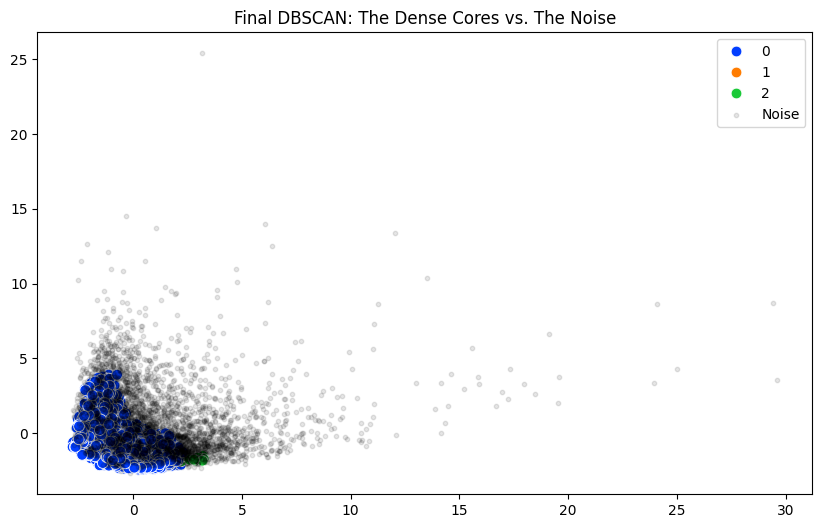

In [51]:
# Final Run with the "Winner" parameters
dbscan_final = DBSCAN(eps=1.0, min_samples=10)
labels_final = dbscan_final.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(10,6))

# Plot the 3 Clusters (Colors)
sns.scatterplot(x=X_pca[labels_final != -1, 0],
                y=X_pca[labels_final != -1, 1],
                hue=labels_final[labels_final != -1],
                palette='bright', s=60, legend='full')

# Plot the Noise (Gray)
plt.scatter(X_pca[labels_final == -1, 0],
            X_pca[labels_final == -1, 1],
            s=10, c='black', alpha=0.1, label='Noise')

plt.title("Final DBSCAN: The Dense Cores vs. The Noise")
plt.legend()
plt.show()

**The Takeaway:** In this specific business case, **K-Means was actually better** for segmentation because we wanted to force everyone into a group. DBSCAN is better if you want to find **Fraud** (The noise points) or distinct, separated islands.